# Module tests

In [1]:
import cv2
import numpy as np
import imregpoc

In [2]:
# for visualize
from matplotlib import pyplot as plt
%matplotlib inline

## Phase correlation module test

Text(0.5, 1.0, 'compared')

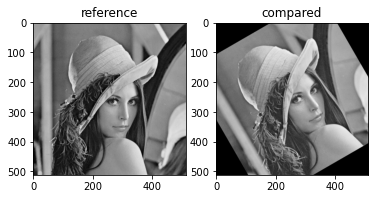

In [3]:
# read monocular image
ref = cv2.imread('imgs/lena.png',0)
#cmp = cv2.imread('saved_imgs/translated_30_lena.png',0) 
cmp = cv2.imread('saved_imgs/rotated_30_lena.png',0)
plt.subplot(121)
plt.imshow(ref,cmap='gray')
plt.title("reference")
plt.subplot(122)
plt.imshow(cmp,cmap='gray')
plt.title("compared")

Init the image matching class

In [4]:
# initialization
result = imregpoc.imregpoc(ref,cmp)

get transformation matrix

In [5]:
result.getPerspective()

array([[  0.8667437,   0.5007727, -94.07514  ],
       [ -0.5007727,   0.8667437, 162.27536  ],
       [  0.       ,   0.       ,   1.       ]], dtype=float32)

get transformation parameter
[ dx
  dy
  $\theta$
  scale]

In [6]:
result.getParam()

[0.025867485, -0.026672298, 0.5239085, 1.0010084540781587]

check wheather this extraction is valid or not

In [7]:
result.isSucceed()

1

show stitched image

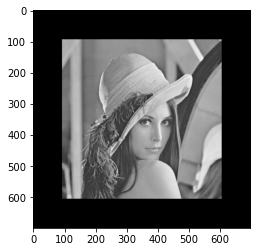

In [8]:
result.stitching()

## Feature point based matching module test

Matched Points Number:1009


([array([-0.15202661]),
  array([0.07062003]),
  30.005441116133547,
  0.9999254778300947],
 584,
 570)

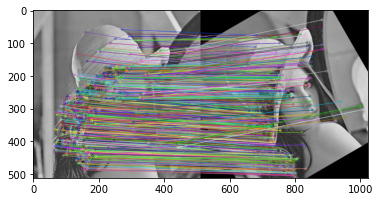

In [9]:
# initialization (SIFT can be changed to other descriptor)
#matcher = imregpoc.TempMatcher(ref,'AKAZE') #OK 
matcher = imregpoc.TempMatcher(ref,'SIFT') #OK 
#matcher = imregpoc.TempMatcher(ref,'KAZE') #OK
#matcher = imregpoc.TempMatcher(ref,'FREAK') #OK
#matcher = imregpoc.TempMatcher(ref,'ORB') #OK 
#matcher = imregpoc.TempMatcher(ref,'SURF') #NG
matcher.match(cmp,1)

Scaling: 
Matched Points Number:1009


0.9999254778300947

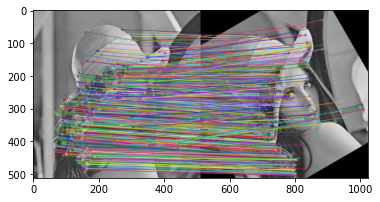

In [10]:
print("Scaling: ")
matcher.match(cmp,1)[0][3]

Rotation: 
Matched Points Number:1009


30.005441116133547

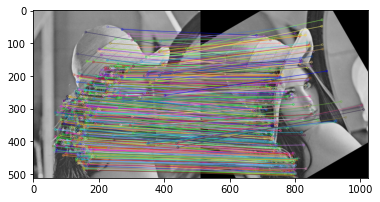

In [11]:
print("Rotation: ")
matcher.match(cmp,1)[0][2]

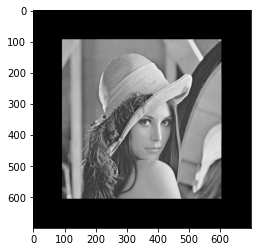

In [12]:
# perspective transformation matrix (Homography matrix)
matcher.getPerspective()
# stitching two images based on the matching result
matcher.stitching()

## Debug


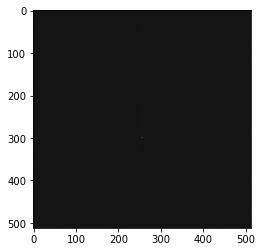

[0.025867485, -0.026672298, 0.5239085, 1.0010084540781587]

In [13]:
result.showRotatePeak()
result.getParam()

### try zeropadding

- 外側に0埋めすればPerspectiveは外のでOK。
- この場合Affineもそういうふうに計算する。
- POCへの変換はどうする？

(512, 512)

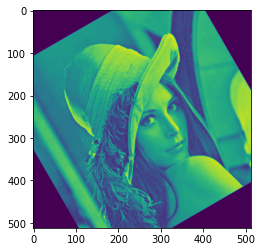

In [14]:
#ref_pad = np.pad(ref,[(0,256-ref.shape[0]),(0,256-ref.shape[1])],'constant')
#ref_pad = cv2.imread('saved_imgs/translated_30_lena.png',0)
ref_pad = cv2.imread('saved_imgs/rotated_30_lena.png',0)
plt.imshow(ref_pad)
ref_pad.shape

In [15]:
#cmp_pad = np.pad(cmp,[(0,256-ref.shape[0]),(0,256-ref.shape[1])],'constant')
cmp_pad = cv2.imread('imgs/lena.png',0)
res_pad = imregpoc.imregpoc(ref_pad,cmp_pad)

In [16]:
res_pad.isSucceed()

1

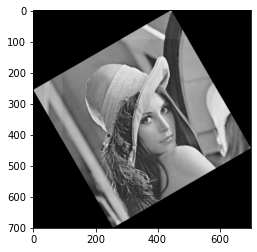

In [17]:
res_pad.stitching()

In [18]:
res_pad.getAffine()

array([[  0.86499816,  -0.49976423, 162.50012   ],
       [  0.49976423,   0.86499816, -93.37918   ]], dtype=float32)

In [19]:
res_pad.getPerspective()

array([[  0.86499816,  -0.49976423, 162.50012   ],
       [  0.49976423,   0.86499816, -93.37918   ],
       [  0.        ,   0.        ,   1.        ]], dtype=float32)

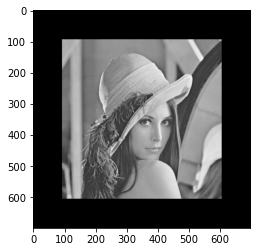

In [20]:
result.stitching(perspective=res_pad.getPerspective())

In [21]:
persp = res_pad.getPerspective()

cx,cy = res_pad.center
Center = np.float32([[1,0,cx],[0,1,cy],[0,0,1]])
iCenter = np.float32([[1,0,-cx],[0,1,-cy],[0,0,1]])

pocmatrix = np.dot(np.dot(iCenter,persp),Center)
dxy = np.dot(np.linalg.inv(pocmatrix[0:2,0:2]),pocmatrix[0:2,2])
scale = np.sqrt(pocmatrix[0,0]**2+pocmatrix[0,1]**2) 
theta = np.arctan2(pocmatrix[0,1],pocmatrix[0,0])
if theta < 0:
    angle = -1 * (theta * 180 / np.pi)
else: 
    angle =  1 * (theta * 180 / np.pi)
print(dxy,scale,theta,angle)

[ 6.6127295e-06 -3.8205926e-06] 0.9989925471784684 -0.5239085 30.01774566628975


In [22]:
res_pad.getParam()

[6.6127295e-06, -3.8205926e-06, -0.5239085, 0.9989925471784684]

In [23]:
res_pad.poc2warp(res_pad.center,res_pad.getParam())

array([[  0.86499816,  -0.4997642 , 162.50012   ],
       [  0.4997642 ,   0.86499816, -93.37915   ],
       [  0.        ,   0.        ,   1.        ]], dtype=float32)

In [24]:
res_pad.poc2warp(res_pad.center,[dxy[0],dxy[1],theta,scale])

array([[  0.86499816,  -0.4997642 , 162.50012   ],
       [  0.4997642 ,   0.86499816, -93.37915   ],
       [  0.        ,   0.        ,   1.        ]], dtype=float32)

In [25]:
def warp2poc(self,center,perspective):
    cx,cy = center
    Center = np.float32([[1,0,cx],[0,1,cy],[0,0,1]])
    iCenter = np.float32([[1,0,-cx],[0,1,-cy],[0,0,1]])

    pocmatrix = np.dot(np.dot(iCenter,persp),Center)
    dxy = np.dot(np.linalg.inv(pocmatrix[0:2,0:2]),pocmatrix[0:2,2])
    scale = np.sqrt(pocmatrix[0,0]**2+pocmatrix[0,1]**2) 
    theta = np.arctan2(pocmatrix[0,1],pocmatrix[0,0])
    if theta < 0:
        angle = -1 * (theta * 180 / np.pi)
    else: 
        angle =  1 * (theta * 180 / np.pi)
    return [dxy[0],dxy[1],theta,scale,angle]

In [26]:
max(ref.shape)
print(dxy,scale,theta,angle)

[ 6.6127295e-06 -3.8205926e-06] 0.9989925471784684 -0.5239085 30.01774566628975
